# Preliminaries

Please make sure you have all libraries (including transformers) are installed and files with data are stored in `friends-classification` subdirectory of the current directory.

The model was trained on NVIDIA GTX 1070.

In [1]:
! python -V

Python 3.9.7


In [2]:
#! pip install transformers

In [3]:
import random 
import time
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel, AdamW

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [4]:
%cd friends-classification/
!mkdir models
! ls

/home/andrew/ml/friends-classification
mkdir: cannot create directory ‘models’: File exists
example_eng_ru.csv
fb_model_translate_en_ru_2_friend_response_test.csv
fb_model_translate_en_ru_2_friend_response_train.csv
fb_model_translate_en_ru_2_friend_response_val.csv
fb_model_translate_en_ru_2_other_speaker_test.csv
fb_model_translate_en_ru_2_other_speaker_train.csv
fb_model_translate_en_ru_2_other_speaker_val.csv
fb_model_translate_ru_en_1_friend_response_test.csv
fb_model_translate_ru_en_1_friend_response_train.csv
fb_model_translate_ru_en_1_friend_response_val.csv
fb_model_translate_ru_en_1_other_speaker_test.csv
fb_model_translate_ru_en_1_other_speaker_train.csv
fb_model_translate_ru_en_1_other_speaker_val.csv
final_model.pt
helsinki_model_translate_ru_en_1_friend_response_test.csv
helsinki_model_translate_ru_en_1_friend_response_train.csv
helsinki_model_translate_ru_en_1_friend_response_val.csv
helsinki_model_translate_ru_en_1_other_speaker_test.csv
helsinki_model_translate_ru_en_1

In [5]:
torch.cuda.is_available()

True

# Dataset Preparation & Basic EDA

In [6]:
#CHECKPOINT = "sberbank-ai/sbert_large_nlu_ru"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-05
#tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
CHECKPOINT = "sberbank-ai/ruBert-base"
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT)

In [7]:
df_train = pd.read_csv('train_data.csv').rename({'Category': 'label'}, axis=1)
df_train.other_speaker.fillna('', inplace=True)
df_val = pd.read_csv('val_data.csv')
df_val.other_speaker.fillna('', inplace=True)
df_test = pd.read_csv('test.csv')
df_test.other_speaker.fillna('', inplace=True)

# Encoding target variable
names_to_cats = LabelEncoder()
df_train['label_code'] = names_to_cats.fit_transform(df_train.label)
df_val['label_code'] = names_to_cats.transform(df_val.label)
df_full = pd.concat([df_train, df_val])
print(df_train["label"].value_counts()/df_train.shape[0])
print()
print(df_val["label"].value_counts()/df_val.shape[0])

РОСС       0.176569
РЕЙЧЕЛ     0.176089
ЧЕНДЛЕР    0.170568
ДЖОУИ      0.166287
МОНИКА     0.160525
ФИБИ       0.149962
Name: label, dtype: float64

РОСС       0.176746
РЕЙЧЕЛ     0.176026
ЧЕНДЛЕР    0.170626
ДЖОУИ      0.166307
МОНИКА     0.160547
ФИБИ       0.149748
Name: label, dtype: float64


In [8]:
print(df_train.shape, df_val.shape, df_test.shape)
df_val

(24993, 5) (2778, 5) (3086, 3)


,Id,other_speaker,friend_response,label,label_code
0,0,"Ладно, а мы вообще не обедаем?","Давай, пора стать серьезным, сбиться с толку. ...",МОНИКА,1
1,1,"Ладно, ладно, послушай, я знаю, что сегодня ве...","Ладно, вот и все! Слезь с нее!",РОСС,3
2,2,"Ага. Знаешь, у меня есть все эти чувства, и я ...","Хорошо, я видела довольно большого голубя.",ДЖОУИ,0
3,3,"Боже мой! один пару минут назад, а теперь я.","Постой, ты не можешь здесь рожать! То есть я н...",МОНИКА,1
4,4,"Не такой, как он сам по себе, просто не такой,...","Посмотрите, это художник, ранее известный как ...",РОСС,3
...,...,...,...,...,...
2773,2773,Что сегодня вечером?,Это наше первое официальное свидание. Наше пер...,РЕЙЧЕЛ,2
2774,2774,"Эй, а ты не переоделась?","Да, и на этот раз вам лучше убедиться, что он ...",РЕЙЧЕЛ,2
2775,2775,Тебя там не было!,"Нет, но это, знаете, просто забавная картинка,...",РОСС,3
2776,2776,Вы говорите по телефону!,"Это была пожарная часть, у нас пожар был!",РЕЙЧЕЛ,2


In [9]:
class FriendsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, padding='max_length', 
                 with_labels=True):

        self.dataframe = dataframe  # pandas dataframe
        #Initialize the tokenizer
        self.tokenizer = tokenizer  
        self.padding = padding
        self.max_length = max_length
        
        self.with_labels = with_labels 
        if 'label' not in self.dataframe.columns:
          self.with_labels = False

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = self.dataframe.other_speaker.iloc[index]
        sent2 = self.dataframe.friend_response.iloc[index]

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1, sent2, 
                                      padding=self.padding,  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.max_length,  
                                      return_tensors='pt')  # Return torch.Tensor objects
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.dataframe.label_code.iloc[index]
            return token_ids, attn_masks, token_type_ids, label  
        else:
            return token_ids, attn_masks, token_type_ids

### How tokenized and encoded text looks

In [10]:
encoded_input = tokenizer(df_val.other_speaker[:2].to_list(), padding=True)
print(encoded_input)
tokenizer.batch_decode(encoded_input["input_ids"])

{'input_ids': [[101, 9006, 121, 106, 945, 2167, 672, 18111, 686, 161, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 9006, 121, 9006, 121, 24103, 378, 121, 119, 2289, 121, 693, 1806, 4331, 1231, 50085, 31392, 24625, 121, 750, 736, 818, 5409, 121, 119, 9268, 113, 4775, 5617, 121, 785, 947, 27480, 1499, 121, 107, 119, 1293, 3371, 52885, 114, 1905, 107, 45808, 1679, 121, 3823, 377, 378, 121, 6254, 2808, 121, 1293, 121, 1293, 67095, 1024, 126, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

['[CLS] ладно, а мы вообще не обедаем? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] ладно, ладно, послушаи, я знаю, что сегодня веду себя мистером несоответствующим, но это так тяжело, я имею в виду увидеть, как ты гуляешь, и я просто хочу прикоснуться к тебе и обнять тебя, даваи, никого рядом, просто, просто поцелуи меня. [SEP]']

In [11]:
encoded_input = tokenizer(
    df_val.other_speaker[2], df_val.friend_response[2], padding=True)
print(encoded_input)
tokenizer.decode(encoded_input["input_ids"])

{'input_ids': [101, 20054, 126, 5075, 121, 118, 1024, 1114, 780, 1090, 6724, 121, 107, 119, 672, 2289, 121, 693, 110, 3192, 2555, 121, 1747, 693, 119, 672, 1385, 20345, 785, 3122, 20900, 378, 1266, 121, 107, 736, 8501, 121, 1747, 693, 1098, 672, 6474, 3269, 121, 119, 9268, 113, 4775, 780, 121, 693, 119, 784, 34083, 21338, 1102, 3371, 3641, 46962, 2774, 126, 1293, 18341, 121, 10302, 161, 4029, 16437, 121, 4029, 3384, 121, 1293, 110, 5477, 133, 696, 121, 110, 5477, 1098, 22819, 107, 1309, 3730, 121, 693, 795, 5190, 126, 119, 9268, 113, 4775, 121, 693, 660, 3641, 40184, 2774, 784, 34083, 21338, 1102, 818, 194, 4759, 194, 2775, 680, 126, 785, 6568, 9229, 1336, 161, 102, 2184, 121, 119, 7539, 3662, 8129, 64474, 126, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

'[CLS] ага. знаешь, у меня есть все эти чувства, и я не знаю, что с ними делать, потому что я не могу встречаться как нормальныи человек, и это нормально, потому что мне не нужны отношения, я имею в виду все, что я деиствительно хочу одну отличную ночь. просто секс, понимаешь? никаких условии, никаких отношении, просто с кем - то, с кем мне комфортно и кто знает, что он делает. я имею в виду, что на одну прекрасную ночь деиствительно так … трудно … наити. как прошел твои день? [SEP] хорошо, я видела довольно большого голубя. [SEP]'

Text(0, 0.5, 'N of occurencies')

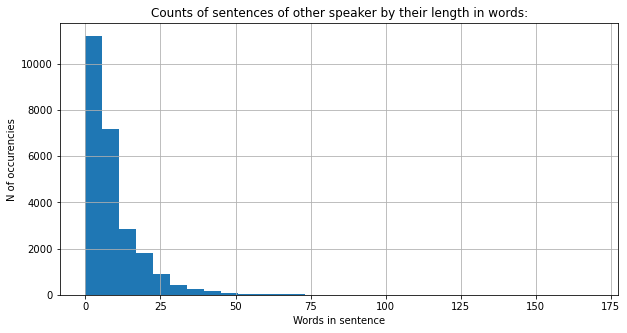

In [12]:
seq_len = [len(i.split()) for i in df_train.other_speaker.fillna('')]
pd.Series(seq_len).hist(bins = 30, figsize=(10, 5))
plt.title('Counts of sentences of other speaker by their length in words:')
plt.xlabel('Words in sentence')
plt.ylabel('N of occurencies')

30857 number of all dialogues in train, validation and test


17     0.000130
18     0.000227
19     0.000454
20     0.000843
21     0.001556
         ...   
505    0.997731
507    0.997829
509    0.997861
510    0.997894
512    0.997958
Name: seq_len, Length: 470, dtype: float64

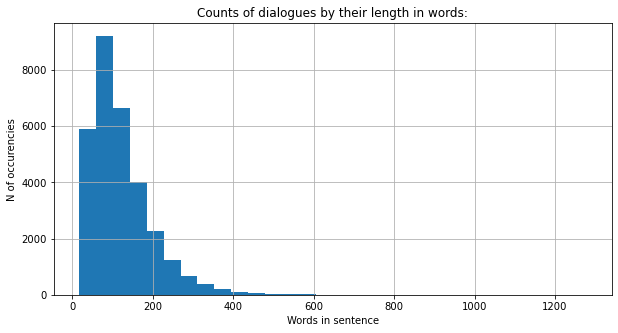

In [13]:
dfs_all = pd.concat([df_train, df_val, df_test])
dfs_all['seq_len'] = dfs_all.apply(lambda row: 
                                   len(row['other_speaker'] + row['friend_response']), axis=1)
print(len(dfs_all), "number of all dialogues in train, validation and test")
[len(i.split()) for i in dfs_all.other_speaker]
dfs_all['seq_len'].hist(bins = 30, figsize=(10, 5))
plt.title('Counts of dialogues by their length in words:')
plt.xlabel('Words in sentence')
plt.ylabel('N of occurencies')
dfs_all['seq_len'].value_counts().sort_index(ascending=True)\
    .cumsum().loc[:512] / len(dfs_all)

In [14]:
df_train.other_speaker.describe()

count     24993
unique    21269
top        Что?
freq        263
Name: other_speaker, dtype: object

In [15]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

# Training loop and predictions

In [16]:
class SentencePairClassifier(nn.Module):

    def __init__(self, model=CHECKPOINT, freeze_model=True):
        super(SentencePairClassifier, self).__init__()
        #  Instantiating BERT-based model object
        # self.pretrained_layer = AutoModel.from_pretrained(CHECKPOINT)
        self.pretrained_layer = BertModel.from_pretrained(CHECKPOINT)

        hidden_size = self.pretrained_layer.config.hidden_size

        # Freeze model layers and only train the classification layer weights
        if freeze_model:
            for p in self.pretrained_layer.parameters():
                p.requires_grad = False
            print('All parameters frozen')
        # Classification layer
        self.cls_layer = nn.Linear(hidden_size, 6)

        self.dropout = nn.Dropout(p=0.3)

    @autocast()  # run in mixed precision
    def forward(self, input_ids, attn_masks, token_type_ids):
        '''
        Inputs:
            -input_ids : Tensor  containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        # Feeding the inputs to the BERT-based model to obtain contextualized representations
        output = self.pretrained_layer(input_ids, attn_masks, token_type_ids)

        logits = self.cls_layer(self.dropout(output.pooler_output))

        return logits

In [17]:
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    

def evaluate_loss(net, device, criterion, dataloader):
    net.eval()
    n_correct = 0
    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            mean_loss += criterion(logits.squeeze(-1), labels).item()
            count += 1
            max_logits, argmax_idx = torch.max(logits.data, dim=1)
            n_correct += calcuate_accu(argmax_idx, labels)
    del logits
    return mean_loss / count, n_correct / len(dataloader.dataset)
  
# Function to calculate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [18]:
def train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    best_acc = 0
    best_ep = 1
    n_iterations = len(train_loader)
    batch_size = train_loader.batch_size
    print_every = 1000 // batch_size  # print the training loss this many times per epoch
    print_eval_iters = 10000 // batch_size
    scaler = GradScaler()

    for ep in range(epochs):
        net.train()
        curr_loss = 0.0
        curr_n_correct = 0.
        trailing_loss = 0.
        trailing_n_correct = 0.
        curr_n_tr_examples = 0
        trainling_n_tr_examples = 0

        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(train_loader)):
            # Converting to cuda tensors
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
  
            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                pooled = net(seq, attn_masks, token_type_ids)

                # Computing loss
                loss = criterion(pooled.squeeze(-1), labels)
                #print(loss, type(loss))
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged
                # Computing accuracy
                #print(pooled.squeeze(-1), labels)
                curr_loss += loss.item() 
                big_val, big_idx = torch.max(pooled.data, dim=1)
                n_correct = calcuate_accu(big_idx, labels)
                curr_n_correct += n_correct

            trailing_loss += loss.item() 
            trailing_n_correct += n_correct
            curr_n_tr_examples += labels.size(0)
            trainling_n_tr_examples += labels.size(0)

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Batch {}/{} of epoch {} complete. Loss per last {} samples:: {} "
                      .format(it+1, n_iterations, ep+1, curr_n_tr_examples, curr_loss / print_every))
                accu_step = (curr_n_correct*100) / curr_n_tr_examples 
                #print(f"Training Loss per 5000 steps: {loss_step}")
                print(f"Training Accuracy per last {curr_n_tr_examples} samples: {accu_step}")
                curr_loss = 0.0
                curr_n_tr_examples = 0
                curr_n_correct = 0


            if (it + 1) % print_eval_iters == 0 or it ==  n_iterations - 1:
                del pooled, loss
                print("Epoch {}, batch {} complete! Training Loss : {}"
                .format(ep+1, it+1, trailing_loss / (it+1)))
                print("Epoch {}, batch {} complete! Training Accuracy : {}"
                .format(ep+1, it+1, trailing_n_correct / trainling_n_tr_examples))
                val_loss, val_accuracy = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
                #print()
                print("Epoch {}, batch {} complete! Validation Loss : {}".format(ep+1, it+1, val_loss))
                print("Epoch {}, batch {} complete! Validation Accuracy : {}".format(ep+1, it+1,val_accuracy))
                net.train()
                #if val_loss < best_loss:
                if val_accuracy > best_acc:
                    print("Validation loss changed from {} to {}".format(best_loss, val_loss))
                    print("Best validation accuracy improved from {} to {}".format(best_acc, val_accuracy))
                    print()
                    #net_copy = copy.deepcopy(net)  # save a copy of the model
                    best_loss = val_loss
                    best_acc = val_accuracy
                    best_ep = ep + 1
                    # Saving the model
                    #path_to_model='models/{}_lr_{}_val_acc_{}_ep_{}.pt'.format(time.ctime(), lr, round(best_acc, 4), best_ep)
                    #torch.save(net.state_dict(), path_to_model)
                    #print("The model has been saved in {}".format(path_to_model))

    torch.cuda.empty_cache()

In [19]:
from transformers import get_linear_schedule_with_warmup
from transformers import get_constant_schedule
#  Set all seeds to make reproducible results
set_seed(1)

# Creating instances of training and validation set
print("Reading training data...")
#train_set = FriendsDataset(dataframe=df_train, tokenizer=tokenizer, max_length=MAX_LEN)
train_set = FriendsDataset(dataframe=df_full, tokenizer=tokenizer, max_length=MAX_LEN)

print("Reading validation data...")
val_set = FriendsDataset(dataframe=df_val, tokenizer=tokenizer, max_length=MAX_LEN)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SentencePairClassifier(model=CHECKPOINT, freeze_model=False)
print(device)

if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)

criterion = nn.CrossEntropyLoss()
opti = AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
num_warmup_steps = 0 # The number of steps for the warmup phase.
iters_to_accumulate = 2
num_training_steps = EPOCHS * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * EPOCHS  # Necessary to take into account Gradient accumulation
#lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
lr_scheduler = get_constant_schedule(optimizer=opti)


Reading training data...
Reading validation data...


Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [20]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  4%|▎         | 62/1736 [00:45<20:13,  1.38it/s]


Batch 62/1736 of epoch 1 complete. Loss per last 992 samples:: 0.9142559420677924 
Training Accuracy per last 992 samples: 16.532258064516128


  7%|▋         | 124/1736 [01:30<19:26,  1.38it/s]


Batch 124/1736 of epoch 1 complete. Loss per last 992 samples:: 0.9017220774004536 
Training Accuracy per last 992 samples: 17.842741935483872


 11%|█         | 186/1736 [02:15<18:39,  1.38it/s]


Batch 186/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8977102464245211 
Training Accuracy per last 992 samples: 18.447580645161292


 14%|█▍        | 248/1736 [03:00<17:59,  1.38it/s]


Batch 248/1736 of epoch 1 complete. Loss per last 992 samples:: 0.9006879252772177 
Training Accuracy per last 992 samples: 17.641129032258064


 18%|█▊        | 310/1736 [03:45<17:28,  1.36it/s]


Batch 310/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8991797662550404 
Training Accuracy per last 992 samples: 19.052419354838708


 21%|██▏       | 372/1736 [04:29<16:39,  1.37it/s]


Batch 372/1736 of epoch 1 complete. Loss per last 992 samples:: 0.9015458629977319 
Training Accuracy per last 992 samples: 18.649193548387096


 25%|██▌       | 434/1736 [05:14<15:54,  1.36it/s]


Batch 434/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8988888648248488 
Training Accuracy per last 992 samples: 17.43951612903226


 29%|██▊       | 496/1736 [05:59<15:07,  1.37it/s]


Batch 496/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8943131969821069 
Training Accuracy per last 992 samples: 20.463709677419356


 32%|███▏      | 558/1736 [06:44<14:17,  1.37it/s]


Batch 558/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8846824399886593 
Training Accuracy per last 992 samples: 22.580645161290324


 36%|███▌      | 620/1736 [07:29<13:29,  1.38it/s]


Batch 620/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8935738840410786 
Training Accuracy per last 992 samples: 19.556451612903224


 36%|███▌      | 624/1736 [07:31<13:30,  1.37it/s]

Epoch 1, batch 625 complete! Training Loss : 0.8986157470703126
Epoch 1, batch 625 complete! Training Accuracy : 0.1887


 36%|███▌      | 625/1736 [08:15<4:10:20, 13.52s/it]

Epoch 1, batch 625 complete! Validation Loss : 1.7546246408045978
Epoch 1, batch 625 complete! Validation Accuracy : 0.25593952483801297
Validation loss changed from inf to 1.7546246408045978
Best validation accuracy improved from 0 to 0.25593952483801297



 39%|███▉      | 682/1736 [08:56<12:30,  1.41it/s]


Batch 682/1736 of epoch 1 complete. Loss per last 992 samples:: 0.890287829983619 
Training Accuracy per last 992 samples: 20.06048387096774


 43%|████▎     | 744/1736 [09:40<11:50,  1.40it/s]


Batch 744/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8921393117597026 
Training Accuracy per last 992 samples: 20.06048387096774


 46%|████▋     | 806/1736 [10:25<11:11,  1.39it/s]


Batch 806/1736 of epoch 1 complete. Loss per last 992 samples:: 0.897947988202495 
Training Accuracy per last 992 samples: 21.975806451612904


 50%|█████     | 868/1736 [11:10<10:27,  1.38it/s]


Batch 868/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8831523772208921 
Training Accuracy per last 992 samples: 22.379032258064516


 54%|█████▎    | 930/1736 [11:54<09:47,  1.37it/s]


Batch 930/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8777606102728075 
Training Accuracy per last 992 samples: 25.806451612903224


 57%|█████▋    | 992/1736 [12:39<09:06,  1.36it/s]


Batch 992/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8713051580613659 
Training Accuracy per last 992 samples: 25.907258064516128


 61%|██████    | 1054/1736 [13:24<08:19,  1.37it/s]


Batch 1054/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8736240017798639 
Training Accuracy per last 992 samples: 25.504032258064516


 64%|██████▍   | 1116/1736 [14:09<07:29,  1.38it/s]


Batch 1116/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8692367307601436 
Training Accuracy per last 992 samples: 25.302419354838708


 68%|██████▊   | 1178/1736 [14:54<06:42,  1.39it/s]


Batch 1178/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8587212101105721 
Training Accuracy per last 992 samples: 28.629032258064516


 71%|███████▏  | 1240/1736 [15:38<06:02,  1.37it/s]


Batch 1240/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8501249744046119 
Training Accuracy per last 992 samples: 28.024193548387096


 72%|███████▏  | 1249/1736 [15:45<05:46,  1.41it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.8871855224609375
Epoch 1, batch 1250 complete! Training Accuracy : 0.2166


 72%|███████▏  | 1250/1736 [16:28<1:49:41, 13.54s/it]

Epoch 1, batch 1250 complete! Validation Loss : 1.6296639278017242
Epoch 1, batch 1250 complete! Validation Accuracy : 0.3362131029517639
Validation loss changed from 1.7546246408045978 to 1.6296639278017242
Best validation accuracy improved from 0.25593952483801297 to 0.3362131029517639



 75%|███████▌  | 1302/1736 [17:06<05:18,  1.36it/s]


Batch 1302/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8515250913558468 
Training Accuracy per last 992 samples: 28.528225806451612


 79%|███████▊  | 1364/1736 [17:51<04:31,  1.37it/s]


Batch 1364/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8515413345829133 
Training Accuracy per last 992 samples: 25.60483870967742


 82%|████████▏ | 1426/1736 [18:35<03:42,  1.39it/s]


Batch 1426/1736 of epoch 1 complete. Loss per last 992 samples:: 0.860899156139743 
Training Accuracy per last 992 samples: 24.697580645161292


 86%|████████▌ | 1488/1736 [19:20<02:57,  1.39it/s]


Batch 1488/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8488450819446195 
Training Accuracy per last 992 samples: 28.931451612903224


 89%|████████▉ | 1550/1736 [20:05<02:13,  1.40it/s]


Batch 1550/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8311971849010836 
Training Accuracy per last 992 samples: 32.056451612903224


 93%|█████████▎| 1612/1736 [20:50<01:29,  1.39it/s]


Batch 1612/1736 of epoch 1 complete. Loss per last 992 samples:: 0.839141599593624 
Training Accuracy per last 992 samples: 30.64516129032258


 96%|█████████▋| 1674/1736 [21:35<00:44,  1.40it/s]


Batch 1674/1736 of epoch 1 complete. Loss per last 992 samples:: 0.8388410383655179 
Training Accuracy per last 992 samples: 29.032258064516128


100%|█████████▉| 1735/1736 [22:19<00:00,  1.39it/s]


Batch 1736/1736 of epoch 1 complete. Loss per last 987 samples:: 0.8412499129772186 
Training Accuracy per last 987 samples: 33.232016210739616
Epoch 1, batch 1736 complete! Training Loss : 0.8755035999527175
Epoch 1, batch 1736 complete! Training Accuracy : 0.23733390947391164


100%|██████████| 1736/1736 [23:02<00:00,  1.26it/s]


Epoch 1, batch 1736 complete! Validation Loss : 1.5837430405890804
Epoch 1, batch 1736 complete! Validation Accuracy : 0.3722102231821454
Validation loss changed from 1.6296639278017242 to 1.5837430405890804
Best validation accuracy improved from 0.3362131029517639 to 0.3722102231821454



  4%|▎         | 62/1736 [00:44<20:16,  1.38it/s]


Batch 62/1736 of epoch 2 complete. Loss per last 992 samples:: 0.8069820404052734 
Training Accuracy per last 992 samples: 35.181451612903224


  7%|▋         | 124/1736 [01:29<19:41,  1.36it/s]


Batch 124/1736 of epoch 2 complete. Loss per last 992 samples:: 0.8048092626756237 
Training Accuracy per last 992 samples: 34.274193548387096


 11%|█         | 186/1736 [02:13<18:52,  1.37it/s]


Batch 186/1736 of epoch 2 complete. Loss per last 992 samples:: 0.8007730053317162 
Training Accuracy per last 992 samples: 35.08064516129032


 14%|█▍        | 248/1736 [02:58<18:03,  1.37it/s]


Batch 248/1736 of epoch 2 complete. Loss per last 992 samples:: 0.8188519016388924 
Training Accuracy per last 992 samples: 35.38306451612903


 18%|█▊        | 310/1736 [03:43<17:25,  1.36it/s]


Batch 310/1736 of epoch 2 complete. Loss per last 992 samples:: 0.8051538775044103 
Training Accuracy per last 992 samples: 33.770161290322584


 21%|██▏       | 372/1736 [04:27<16:30,  1.38it/s]


Batch 372/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7766296940465127 
Training Accuracy per last 992 samples: 39.01209677419355


 25%|██▌       | 434/1736 [05:12<15:41,  1.38it/s]


Batch 434/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7839053676974389 
Training Accuracy per last 992 samples: 35.38306451612903


 29%|██▊       | 496/1736 [05:56<14:56,  1.38it/s]


Batch 496/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7983154173820249 
Training Accuracy per last 992 samples: 35.88709677419355


 32%|███▏      | 558/1736 [06:41<14:15,  1.38it/s]


Batch 558/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7827376704062184 
Training Accuracy per last 992 samples: 37.5


 36%|███▌      | 620/1736 [07:26<13:25,  1.39it/s]


Batch 620/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7769500363257623 
Training Accuracy per last 992 samples: 38.104838709677416


 36%|███▌      | 624/1736 [07:29<13:25,  1.38it/s]

Epoch 2, batch 625 complete! Training Loss : 0.7948761047363281
Epoch 2, batch 625 complete! Training Accuracy : 0.3604


 36%|███▌      | 625/1736 [08:12<4:11:20, 13.57s/it]

Epoch 2, batch 625 complete! Validation Loss : 1.451727505387931
Epoch 2, batch 625 complete! Validation Accuracy : 0.4528437724982001
Validation loss changed from 1.5837430405890804 to 1.451727505387931
Best validation accuracy improved from 0.3722102231821454 to 0.4528437724982001



 39%|███▉      | 682/1736 [08:53<12:38,  1.39it/s]


Batch 682/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7949572224770823 
Training Accuracy per last 992 samples: 34.778225806451616


 43%|████▎     | 744/1736 [09:38<12:05,  1.37it/s]


Batch 744/1736 of epoch 2 complete. Loss per last 992 samples:: 0.772640505144673 
Training Accuracy per last 992 samples: 36.189516129032256


 46%|████▋     | 806/1736 [10:23<11:13,  1.38it/s]


Batch 806/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7756284590690367 
Training Accuracy per last 992 samples: 37.70161290322581


 50%|█████     | 868/1736 [11:08<10:29,  1.38it/s]


Batch 868/1736 of epoch 2 complete. Loss per last 992 samples:: 0.8023288788334015 
Training Accuracy per last 992 samples: 34.57661290322581


 54%|█████▎    | 930/1736 [11:53<09:43,  1.38it/s]


Batch 930/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7891144291047127 
Training Accuracy per last 992 samples: 35.28225806451613


 57%|█████▋    | 992/1736 [12:37<09:02,  1.37it/s]


Batch 992/1736 of epoch 2 complete. Loss per last 992 samples:: 0.814882093860257 
Training Accuracy per last 992 samples: 32.25806451612903


 61%|██████    | 1054/1736 [13:22<08:20,  1.36it/s]


Batch 1054/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7836554434991652 
Training Accuracy per last 992 samples: 37.600806451612904


 64%|██████▍   | 1116/1736 [14:07<07:35,  1.36it/s]


Batch 1116/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7634975987095987 
Training Accuracy per last 992 samples: 38.70967741935484


 68%|██████▊   | 1178/1736 [14:52<06:49,  1.36it/s]


Batch 1178/1736 of epoch 2 complete. Loss per last 992 samples:: 0.788209730579007 
Training Accuracy per last 992 samples: 37.19758064516129


 71%|███████▏  | 1240/1736 [15:37<06:01,  1.37it/s]


Batch 1240/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7837414280060799 
Training Accuracy per last 992 samples: 35.28225806451613


 72%|███████▏  | 1249/1736 [15:43<05:52,  1.38it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.7909677093505859
Epoch 2, batch 1250 complete! Training Accuracy : 0.35985


 72%|███████▏  | 1250/1736 [16:27<1:49:48, 13.56s/it]

Epoch 2, batch 1250 complete! Validation Loss : 1.3701171875
Epoch 2, batch 1250 complete! Validation Accuracy : 0.5003599712023038
Validation loss changed from 1.451727505387931 to 1.3701171875
Best validation accuracy improved from 0.4528437724982001 to 0.5003599712023038



 75%|███████▌  | 1302/1736 [17:04<05:14,  1.38it/s]


Batch 1302/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7926104760939076 
Training Accuracy per last 992 samples: 34.57661290322581


 79%|███████▊  | 1364/1736 [17:49<04:27,  1.39it/s]


Batch 1364/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7930367377496534 
Training Accuracy per last 992 samples: 34.87903225806452


 82%|████████▏ | 1426/1736 [18:33<03:44,  1.38it/s]


Batch 1426/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7733944616010112 
Training Accuracy per last 992 samples: 38.810483870967744


 86%|████████▌ | 1488/1736 [19:18<02:58,  1.39it/s]


Batch 1488/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7829858103106099 
Training Accuracy per last 992 samples: 36.895161290322584


 89%|████████▉ | 1550/1736 [20:02<02:13,  1.39it/s]


Batch 1550/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7747752897201046 
Training Accuracy per last 992 samples: 38.50806451612903


 93%|█████████▎| 1612/1736 [20:47<01:30,  1.37it/s]


Batch 1612/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7715068632556547 
Training Accuracy per last 992 samples: 37.600806451612904


 96%|█████████▋| 1674/1736 [21:32<00:45,  1.37it/s]


Batch 1674/1736 of epoch 2 complete. Loss per last 992 samples:: 0.7936443821076424 
Training Accuracy per last 992 samples: 36.693548387096776


100%|█████████▉| 1735/1736 [22:15<00:00,  1.39it/s]


Batch 1736/1736 of epoch 2 complete. Loss per last 987 samples:: 0.7790754995038432 
Training Accuracy per last 987 samples: 38.095238095238095
Epoch 2, batch 1736 complete! Training Loss : 0.7887426279656898
Epoch 2, batch 1736 complete! Training Accuracy : 0.36257246768211443


100%|██████████| 1736/1736 [22:59<00:00,  1.26it/s]


Epoch 2, batch 1736 complete! Validation Loss : 1.30810546875
Epoch 2, batch 1736 complete! Validation Accuracy : 0.5212383009359252
Validation loss changed from 1.3701171875 to 1.30810546875
Best validation accuracy improved from 0.5003599712023038 to 0.5212383009359252



  4%|▎         | 62/1736 [00:44<20:16,  1.38it/s]


Batch 62/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6768753913141066 
Training Accuracy per last 992 samples: 49.09274193548387


  7%|▋         | 124/1736 [01:29<19:38,  1.37it/s]


Batch 124/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6816564067717521 
Training Accuracy per last 992 samples: 49.395161290322584


 11%|█         | 186/1736 [02:14<18:41,  1.38it/s]


Batch 186/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6706525433448053 
Training Accuracy per last 992 samples: 48.99193548387097


 14%|█▍        | 248/1736 [02:58<18:04,  1.37it/s]


Batch 248/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6693052476452243 
Training Accuracy per last 992 samples: 49.596774193548384


 18%|█▊        | 310/1736 [03:43<17:19,  1.37it/s]


Batch 310/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6565530530868038 
Training Accuracy per last 992 samples: 51.20967741935484


 21%|██▏       | 372/1736 [04:28<16:37,  1.37it/s]


Batch 372/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6532707829629222 
Training Accuracy per last 992 samples: 50.70564516129032


 25%|██▌       | 434/1736 [05:12<15:29,  1.40it/s]


Batch 434/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6828036000651698 
Training Accuracy per last 992 samples: 47.78225806451613


 29%|██▊       | 496/1736 [05:57<14:55,  1.38it/s]


Batch 496/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6695453274634576 
Training Accuracy per last 992 samples: 49.899193548387096


 32%|███▏      | 558/1736 [06:42<14:12,  1.38it/s]


Batch 558/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6772743194333969 
Training Accuracy per last 992 samples: 47.37903225806452


 36%|███▌      | 620/1736 [07:27<13:18,  1.40it/s]


Batch 620/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6840108133131458 
Training Accuracy per last 992 samples: 47.983870967741936


 36%|███▌      | 624/1736 [07:30<13:14,  1.40it/s]

Epoch 3, batch 625 complete! Training Loss : 0.672509683227539
Epoch 3, batch 625 complete! Training Accuracy : 0.4917


 36%|███▌      | 625/1736 [08:13<4:11:38, 13.59s/it]

Epoch 3, batch 625 complete! Validation Loss : 1.1083872126436782
Epoch 3, batch 625 complete! Validation Accuracy : 0.615190784737221
Validation loss changed from 1.30810546875 to 1.1083872126436782
Best validation accuracy improved from 0.5212383009359252 to 0.615190784737221



 39%|███▉      | 682/1736 [08:54<12:47,  1.37it/s]


Batch 682/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6626892397480626 
Training Accuracy per last 992 samples: 49.49596774193548


 43%|████▎     | 744/1736 [09:39<11:59,  1.38it/s]


Batch 744/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6731918242669874 
Training Accuracy per last 992 samples: 47.78225806451613


 46%|████▋     | 806/1736 [10:24<11:16,  1.37it/s]


Batch 806/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6798993079893051 
Training Accuracy per last 992 samples: 47.88306451612903


 50%|█████     | 868/1736 [11:08<10:37,  1.36it/s]


Batch 868/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6515380797847625 
Training Accuracy per last 992 samples: 51.00806451612903


 54%|█████▎    | 930/1736 [11:53<09:46,  1.37it/s]


Batch 930/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6720427697704684 
Training Accuracy per last 992 samples: 47.58064516129032


 57%|█████▋    | 992/1736 [12:38<09:04,  1.37it/s]


Batch 992/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6550033784681751 
Training Accuracy per last 992 samples: 49.69758064516129


 61%|██████    | 1054/1736 [13:22<08:16,  1.37it/s]


Batch 1054/1736 of epoch 3 complete. Loss per last 992 samples:: 0.66969879211918 
Training Accuracy per last 992 samples: 48.48790322580645


 64%|██████▍   | 1116/1736 [14:07<07:32,  1.37it/s]


Batch 1116/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6956402870916552 
Training Accuracy per last 992 samples: 46.57258064516129


 68%|██████▊   | 1178/1736 [14:51<06:42,  1.39it/s]


Batch 1178/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6784681043317241 
Training Accuracy per last 992 samples: 48.08467741935484


 71%|███████▏  | 1240/1736 [15:36<06:00,  1.38it/s]


Batch 1240/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6868589001317178 
Training Accuracy per last 992 samples: 47.37903225806452


 72%|███████▏  | 1249/1736 [15:43<05:48,  1.40it/s]

Epoch 3, batch 1250 complete! Training Loss : 0.6725999572753906
Epoch 3, batch 1250 complete! Training Accuracy : 0.48745


 72%|███████▏  | 1250/1736 [16:26<1:49:26, 13.51s/it]

Epoch 3, batch 1250 complete! Validation Loss : 0.9910509832974138
Epoch 3, batch 1250 complete! Validation Accuracy : 0.6882649388048956
Validation loss changed from 1.1083872126436782 to 0.9910509832974138
Best validation accuracy improved from 0.615190784737221 to 0.6882649388048956



 75%|███████▌  | 1302/1736 [17:03<05:16,  1.37it/s]


Batch 1302/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6839275052470546 
Training Accuracy per last 992 samples: 47.88306451612903


 79%|███████▊  | 1364/1736 [17:48<04:29,  1.38it/s]


Batch 1364/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6840720176696777 
Training Accuracy per last 992 samples: 48.891129032258064


 82%|████████▏ | 1426/1736 [18:33<03:46,  1.37it/s]


Batch 1426/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6924420018349925 
Training Accuracy per last 992 samples: 44.45564516129032


 86%|████████▌ | 1488/1736 [19:17<03:01,  1.37it/s]


Batch 1488/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6624703099650722 
Training Accuracy per last 992 samples: 50.30241935483871


 89%|████████▉ | 1550/1736 [20:02<02:13,  1.40it/s]


Batch 1550/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6705495772823211 
Training Accuracy per last 992 samples: 49.29435483870968


 93%|█████████▎| 1612/1736 [20:47<01:29,  1.38it/s]


Batch 1612/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6711762335992628 
Training Accuracy per last 992 samples: 48.79032258064516


 96%|█████████▋| 1674/1736 [21:32<00:45,  1.38it/s]


Batch 1674/1736 of epoch 3 complete. Loss per last 992 samples:: 0.6754532783262192 
Training Accuracy per last 992 samples: 48.38709677419355


100%|█████████▉| 1735/1736 [22:16<00:00,  1.39it/s]


Batch 1736/1736 of epoch 3 complete. Loss per last 987 samples:: 0.6797780471463357 
Training Accuracy per last 987 samples: 48.02431610942249
Epoch 3, batch 1736 complete! Training Loss : 0.6738159692919199
Epoch 3, batch 1736 complete! Training Accuracy : 0.4864426920168521


100%|██████████| 1736/1736 [22:59<00:00,  1.26it/s]

Epoch 3, batch 1736 complete! Validation Loss : 0.8625740840517241
Epoch 3, batch 1736 complete! Validation Accuracy : 0.751979841612671
Validation loss changed from 0.9910509832974138 to 0.8625740840517241
Best validation accuracy improved from 0.6882649388048956 to 0.751979841612671



In [21]:
torch.save(net.state_dict(), 'models/final_model.pt')

In [22]:
#net.load_state_dict(torch.load('models/final_model.pt'))

In [23]:
test_set = FriendsDataset(dataframe=df_test, tokenizer=tokenizer, max_length=MAX_LEN)
test_loader = DataLoader(test_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=1)
def predict(net, device, dataloader):
    net.eval()
    predictions = []

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            max_logits, argmax_idx = torch.max(logits.data, dim=1)
            predictions.extend(argmax_idx.tolist())
    del logits
    return predictions
preds = predict(net, device, test_loader)

100%|██████████| 193/193 [00:42<00:00,  4.52it/s]


In [24]:
df_test

,Id,other_speaker,friend_response
0,0,"Но я безработный, моя музыка - это все, что у ...",Меня застрелят. Любой совет?
1,1,Посмотри. Пятьсот семнадцать коробок!,"Боже мой, как ты это сделал?"
2,2,"Хорошо. Хорошо. Помогло бы, если бы я подошел ...",Это было бы очень полезно!
3,3,"Росс, чего ты так долго?","Простите, это как будто не для быстрого отдыха!"
4,4,Так кто ты?,"Ну, наши имена действительно Моника и Чендлер...."
...,...,...,...
3081,3081,Дело не только в барабанах. Каждые пять минут ...,"Понимаете, именно так нормальные люди должны р..."
3082,3082,"Кажется, я случайно использовал коробки Моники...","Боже, все испорчено! Папа, она будет раздавлена!"
3083,3083,"ну знаете, вот почему через несколько лет расп...","Ой, это так здорово."
3084,3084,"Он переспал с тобой, а потом никогда тебе не з...",А я просто хотела нового папу для Дэви и Бекки.


In [25]:
answers = pd.DataFrame(
    names_to_cats.inverse_transform(preds), 
    index=df_test.Id, columns=["Category"])
answers.to_csv('final_submission.csv')
answers

,Category
Id,
0,ФИБИ
1,МОНИКА
2,РЕЙЧЕЛ
3,РОСС
4,ЧЕНДЛЕР
...,...
3081,ФИБИ
3082,МОНИКА
3083,РЕЙЧЕЛ


In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
torch.cuda.get_device_properties(0).total_memory / 1e6

8506.769408